In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt

# VGG construction

In [2]:
class VGG(nn.Module):
    def __init__(self, arch, img_size=224, in_channels=1, out_shape=10, activation_fn=nn.GELU):
        super().__init__()
        
        self.activation_fn = activation_fn 
        
        conv_blocks = []
        self.current_size = img_size
        current_channels = in_channels
        for num_convs, out_channels in arch:
            conv_blocks.append(self.vgg_block(num_convs, current_channels, out_channels))
            self.current_size //= 2
            current_channels = out_channels
            
        self.conv_blocks = nn.Sequential(*conv_blocks)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(self.current_size * self.current_size * arch[-1][1]), out_features=4096),
            activation_fn(), nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            activation_fn(), nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=out_shape),
        )
        self.initialize_weights()

    def initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
    
    def vgg_block(self, num_convs, in_channels, out_channels):
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(self.activation_fn())
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.classifier(x)

        return x

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
def train_step(model, train_dataloader, loss_fn, accuracy_fn, optimizer, device="cpu"):
    model.to(device)
    model.train()
    train_loss = train_acc = 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        y_logits = model(X)

        loss = loss_fn(y_logits, y)

        train_loss += loss
        train_acc += accuracy_fn(y_logits.argmax(dim=1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    return train_loss.detach().cpu().item(), train_acc


def test_step(model, train_dataloader, loss_fn, accuracy_fn, device="cpu"):
    model.to(device)
    model.eval()
    test_loss = test_acc = 0
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_logits = model(X)
        
            test_loss += loss_fn(y_logits, y)
            test_acc += accuracy_fn(y_logits.argmax(dim=1), y)
    
    
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
        return test_loss.detach().cpu().item(), test_acc

In [5]:
def accuracy_fn(y_pred, y_true):
    return torch.eq(y_pred, y_true).sum().item() / len(y_true)

# VGG-11

## Image size 56x56

In [6]:
image_size = 56

In [7]:
from torchvision.datasets import FashionMNIST, MNIST
from torchvision.transforms.v2 import Resize, ToTensor, Compose

transforms =Compose([
    Resize((image_size, image_size)),
    ToTensor()
])

train_data = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms,
)

test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms,
)

class_names = train_data.classes

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 299kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.66MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.77MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [9]:
from tqdm.auto import tqdm

model_0 = VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)), img_size=image_size, out_shape=len(class_names))

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model_0.parameters(), lr=0.01, momentum=0.9, nesterov=True)

epoches = 11

train_losses_0 = []
test_losses_0 = []
test_acc_0 = []

for epoche in tqdm(range(epoches)):
    train_info = train_step(model_0, train_dataloader, loss_fn, accuracy_fn, optim, device)
    test_info = test_step(model_0, test_dataloader, loss_fn, accuracy_fn, device)

    if epoche % 2 == 0:
        print(f"Epoche: {epoche}\n---------")
        print(f"Train loss: {train_info[0]:.5f} | Train accuracy: {train_info[1]:.2f}%")
        print(f"Test loss: {test_info[0]:.5f} | Test accuracy: {test_info[1]:.2f}%")

    train_losses_0.append(train_info[0])
    test_losses_0.append(test_info[0])
    test_acc_0.append(test_info[1])

  0%|          | 0/11 [00:00<?, ?it/s]

Epoche: 0
---------
Train loss: 0.87060 | Train accuracy: 0.68%
Test loss: 0.44207 | Test accuracy: 0.85%
Epoche: 2
---------
Train loss: 0.30205 | Train accuracy: 0.89%
Test loss: 0.28989 | Test accuracy: 0.90%
Epoche: 4
---------
Train loss: 0.22798 | Train accuracy: 0.92%
Test loss: 0.25201 | Test accuracy: 0.91%
Epoche: 6
---------
Train loss: 0.17353 | Train accuracy: 0.94%
Test loss: 0.26446 | Test accuracy: 0.91%
Epoche: 8
---------
Train loss: 0.12221 | Train accuracy: 0.95%
Test loss: 0.27667 | Test accuracy: 0.91%
Epoche: 10
---------
Train loss: 0.08226 | Train accuracy: 0.97%
Test loss: 0.29598 | Test accuracy: 0.92%


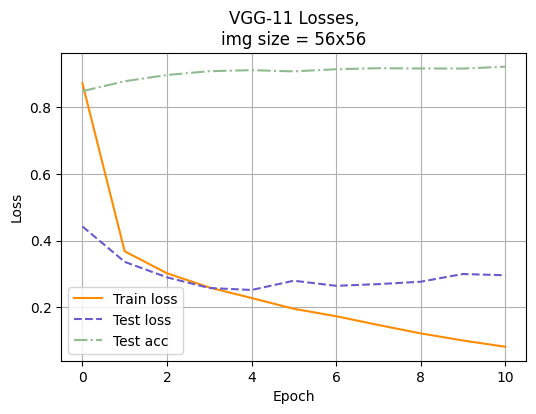

In [10]:
plt.figure(figsize=(6, 4))

plt.plot(range(epoches), train_losses_0, c="darkorange",label="Train loss")
plt.plot(range(epoches), test_losses_0, c="slateblue", ls='dashed', label="Test loss")
plt.plot(range(epoches), test_acc_0, c="darkseagreen", ls='dashdot', label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"VGG-11 Losses,\nimg size = {image_size}x{image_size}")
plt.legend()
plt.grid(True)
plt.show()

## Image size 84x84

In [11]:
image_size = 84

In [12]:
from torchvision.datasets import FashionMNIST, MNIST
from torchvision.transforms.v2 import Resize, ToTensor, Compose

transforms =Compose([
    Resize((image_size, image_size)),
    ToTensor()
])

train_data = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms,
)

test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms,
)

class_names = train_data.classes

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [14]:
from tqdm.auto import tqdm

model_1 = VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)), img_size=image_size, out_shape=len(class_names))

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9, nesterov=True)

epoches = 11

train_losses_1 = []
test_losses_1 = []
test_acc_1 = []

for epoche in tqdm(range(epoches)):
    train_info = train_step(model_1, train_dataloader, loss_fn, accuracy_fn, optim, device)
    test_info = test_step(model_1, test_dataloader, loss_fn, accuracy_fn, device)

    if epoche % 2 == 0:
        print(f"Epoche: {epoche}\n---------")
        print(f"Train loss: {train_info[0]:.5f} | Train accuracy: {train_info[1]:.2f}%")
        print(f"Test loss: {test_info[0]:.5f} | Test accuracy: {test_info[1]:.2f}%")

    train_losses_1.append(train_info[0])
    test_losses_1.append(test_info[0])
    test_acc_1.append(test_info[1])

  0%|          | 0/11 [00:00<?, ?it/s]

Epoche: 0
---------
Train loss: 0.73921 | Train accuracy: 0.73%
Test loss: 0.41405 | Test accuracy: 0.85%
Epoche: 2
---------
Train loss: 0.31293 | Train accuracy: 0.89%
Test loss: 0.31451 | Test accuracy: 0.89%
Epoche: 4
---------
Train loss: 0.23986 | Train accuracy: 0.91%
Test loss: 0.29072 | Test accuracy: 0.89%
Epoche: 6
---------
Train loss: 0.18209 | Train accuracy: 0.93%
Test loss: 0.24135 | Test accuracy: 0.91%
Epoche: 8
---------
Train loss: 0.13173 | Train accuracy: 0.95%
Test loss: 0.26290 | Test accuracy: 0.92%
Epoche: 10
---------
Train loss: 0.09200 | Train accuracy: 0.97%
Test loss: 0.29791 | Test accuracy: 0.92%


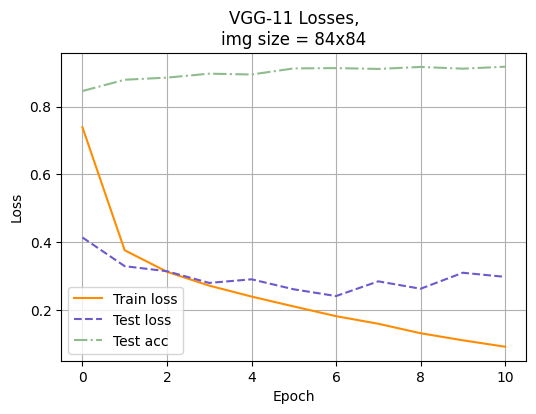

In [15]:
plt.figure(figsize=(6, 4))

plt.plot(range(epoches), train_losses_1, c="darkorange",label="Train loss")
plt.plot(range(epoches), test_losses_1, c="slateblue", ls='dashed', label="Test loss")
plt.plot(range(epoches), test_acc_1, c="darkseagreen", ls='dashdot', label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"VGG-11 Losses,\nimg size = {image_size}x{image_size}")
plt.legend()
plt.grid(True)
plt.show()

# VGG-16

## Image size 56x56

In [16]:
image_size = 84

In [17]:
from torchvision.datasets import FashionMNIST, MNIST
from torchvision.transforms.v2 import Resize, ToTensor, Compose

transforms =Compose([
    Resize((image_size, image_size)),
    ToTensor()
])

train_data = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms,
)

test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms,
)

class_names = train_data.classes

In [18]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [19]:
from tqdm.auto import tqdm

model_2 = VGG(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)), img_size=image_size, out_shape=len(class_names))

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9, nesterov=True)

epoches = 11

train_losses_2 = []
test_losses_2 = []
test_acc_2 = []

for epoche in tqdm(range(epoches)):
    train_info = train_step(model_2, train_dataloader, loss_fn, accuracy_fn, optim, device)
    test_info = test_step(model_2, test_dataloader, loss_fn, accuracy_fn, device)

    if epoche % 2 == 0:
        print(f"Epoche: {epoche}\n---------")
        print(f"Train loss: {train_info[0]:.5f} | Train accuracy: {train_info[1]:.2f}%")
        print(f"Test loss: {test_info[0]:.5f} | Test accuracy: {test_info[1]:.2f}%")

    train_losses_2.append(train_info[0])
    test_losses_2.append(test_info[0])
    test_acc_2.append(test_info[1])

  0%|          | 0/11 [00:00<?, ?it/s]

Epoche: 0
---------
Train loss: 0.99557 | Train accuracy: 0.63%
Test loss: 0.39503 | Test accuracy: 0.85%
Epoche: 2
---------
Train loss: 0.29985 | Train accuracy: 0.89%
Test loss: 0.33870 | Test accuracy: 0.88%
Epoche: 4
---------
Train loss: 0.21558 | Train accuracy: 0.92%
Test loss: 0.32192 | Test accuracy: 0.89%
Epoche: 6
---------
Train loss: 0.14915 | Train accuracy: 0.95%
Test loss: 0.25103 | Test accuracy: 0.92%
Epoche: 8
---------
Train loss: 0.09036 | Train accuracy: 0.97%
Test loss: 0.27467 | Test accuracy: 0.92%
Epoche: 10
---------
Train loss: 0.05886 | Train accuracy: 0.98%
Test loss: 0.36079 | Test accuracy: 0.92%


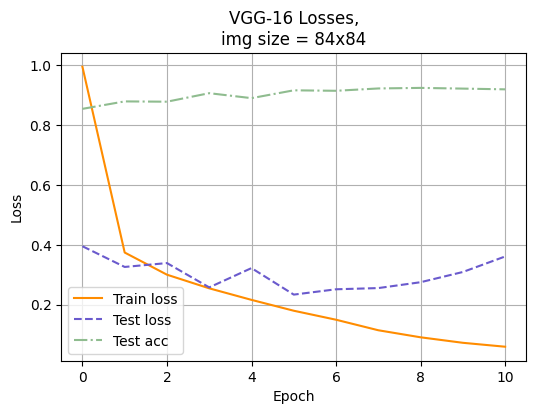

In [20]:
plt.figure(figsize=(6, 4))

plt.plot(range(epoches), train_losses_2, c="darkorange",label="Train loss")
plt.plot(range(epoches), test_losses_2, c="slateblue", ls='dashed', label="Test loss")
plt.plot(range(epoches), test_acc_2, c="darkseagreen", ls='dashdot', label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"VGG-16 Losses,\nimg size = {image_size}x{image_size}")
plt.legend()
plt.grid(True)
plt.show()

# Comparsion

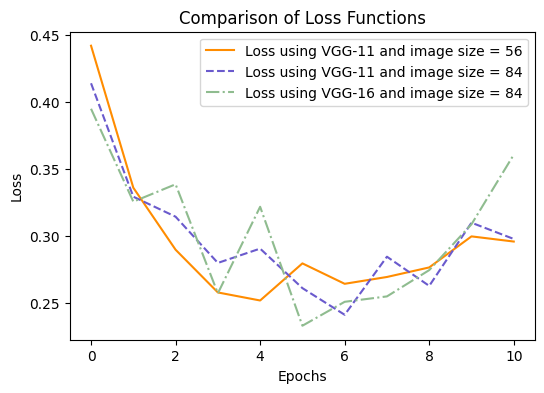

In [21]:
plt.figure(figsize=(6, 4))

plt.plot(range(epoches), test_losses_0, c="darkorange", label="Loss using VGG-11 and image size = 56")
plt.plot(range(epoches), test_losses_1, c="slateblue", ls='dashed', label="Loss using VGG-11 and image size = 84")
plt.plot(range(epoches), test_losses_2, c="darkseagreen", ls='dashdot', label="Loss using VGG-16 and image size = 84")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Comparison of Loss Functions")
plt.legend()
#plt.grid(True)
plt.show()

# Summary

## VGG-11

In [22]:
from torchinfo import summary


summary(model_0, input_size=(1, 1, 56, 56))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Sequential: 2-1                   [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           640
│    │    └─GELU: 3-2                    [1, 64, 56, 56]           --
│    │    └─MaxPool2d: 3-3               [1, 64, 28, 28]           --
│    └─Sequential: 2-2                   [1, 128, 14, 14]          --
│    │    └─Conv2d: 3-4                  [1, 128, 28, 28]          73,856
│    │    └─GELU: 3-5                    [1, 128, 28, 28]          --
│    │    └─MaxPool2d: 3-6               [1, 128, 14, 14]          --
│    └─Sequential: 2-3                   [1, 256, 7, 7]            --
│    │    └─Conv2d: 3-7                  [1, 256, 14, 14]          295,168
│    │    └─GELU: 3-8                    [1, 256, 14, 14]          --
│    

## VGG-16

In [23]:
summary(model_2, input_size=(1, 1, 84, 84))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 2, 2]            --
│    └─Sequential: 2-1                   [1, 64, 42, 42]           --
│    │    └─Conv2d: 3-1                  [1, 64, 84, 84]           640
│    │    └─GELU: 3-2                    [1, 64, 84, 84]           --
│    │    └─Conv2d: 3-3                  [1, 64, 84, 84]           36,928
│    │    └─GELU: 3-4                    [1, 64, 84, 84]           --
│    │    └─MaxPool2d: 3-5               [1, 64, 42, 42]           --
│    └─Sequential: 2-2                   [1, 128, 21, 21]          --
│    │    └─Conv2d: 3-6                  [1, 128, 42, 42]          73,856
│    │    └─GELU: 3-7                    [1, 128, 42, 42]          --
│    │    └─Conv2d: 3-8                  [1, 128, 42, 42]          147,584
│    │    └─GELU: 3-9                    [1, 128, 42, 42]          --
│